In [1]:
import os
os.environ['HF_HOME'] = '/workspace/huggingface'

from transformer_lens import HookedTransformer, ActivationCache, utils
import torch

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
tqdm.pandas()

init_notebook_mode(connected=True)

Device: cuda



## Data Loading

In [74]:
from datasets import load_dataset

dataset = load_dataset("gsm8k", "main")

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

In [ ]:
%%bash
git clone https://github.com/asaparov/prontoqa.git
cd prontoqa
mkdir json
unzip generated_ood_data.zip -d json

In [168]:
import json

def load_json(file):
    with open(file, 'r') as f:
        return json.load(f)
    
data = load_json("prontoqa/json/1hop_ProofsOnly_random_noadj.json")

In [335]:
from random import randint

labels = ["is", "is not"]

def prepare_example(example, n_shots=5):
    prompt = "Answer True or False to the following question. Answer as in the examples.\n\n"
    
    for i in range(n_shots):
        prompt += example[f"in_context_example{i}"]['question'] + "\n"
        query = example[f"in_context_example{i}"]['query']
        label = "False" if "is not" in query else "True"
        
        if "is not" in query:
            #label = "True" if change == 1 else "False"
            #query = query.replace("is not", labels[change])
            name, adj = query.split(" is not ")
        else:
            #label = "True" if change == 0 else "False"
            #query = query.replace("is", labels[change])name, adj = query.split("is not")
            name, adj = query.split(" is ")
        
        name = name.split("Prove: ")[-1]
        query = f"Is {name.strip()} {adj.strip()[:-1]}?\n"
    
        prompt += "Question: " + query + "Think step-by-step." + "\n\n"
    
        for j, step in enumerate(example[f"in_context_example{i}"]['chain_of_thought']):
            prompt += f"({j+1}) {step}\n"
        
        prompt += f"Answer: {label}\n\n"
    
    prompt += example["test_example"]['question'] + "\n"
    query = example["test_example"]['query']
    label = "False" if "is not" in query else "True"
    cot = example["test_example"]['chain_of_thought']
    
    if "is not" in query:
        #label = "True" if change == 1 else "False"
        #query = query.replace("is not", labels[change])
        #adv_query = query.replace("is not", labels[1-change])
        name, adj = query.split(" is not ")
    else:
        #label = "True" if change == 0 else "False"
        #query = query.replace("is", labels[change])
        #adv_query = query.replace("is", labels[1-change])
        name, adj = query.split(" is ")

    #adv_prompt = prompt
    name = name.split("Prove: ")[-1]
    query = f"Is {name.strip()} {adj.strip()[:-1]}?\n"
    
    prompt += "Question: " + query + "Think step-by-step." + "\n\n"
        
    return prompt, label, cot

In [341]:
prompts = [prepare_example(x, n_shots=5) for x in data.values()]

In [342]:
print(prompts[0][0])
print(prompts[0][1])
print(prompts[0][2])

Answer True or False to the following question. Answer as in the examples.

Dumpuses are numpuses. Impuses are jompuses. Each yumpus is not spicy. Every dumpus is mean. Lorpuses are snowy. Each lempus is not transparent. Numpuses are tumpuses. Numpuses are moderate. Every tumpus is luminous. Jompuses are not blue. Impuses are gorpuses. Every gorpus is not hot. Each dumpus is a yumpus. Every gorpus is a lempus. Lorpuses are sterpuses. Every impus is muffled. Every numpus is an impus. Gorpuses are rompuses. Polly is an impus. Polly is a lorpus.
Question: Is Polly muffled?
Think step-by-step.

(1) Polly is an impus.
(2) Every impus is muffled.
(3) Polly is muffled.
Answer: True

Every lempus is a rompus. Each rompus is a jompus. Each jompus is a lorpus. Each rompus is a tumpus. Grimpuses are feisty. Jompuses are cold. Each dumpus is transparent. Each lempus is a dumpus. Rompuses are rainy. Vumpuses are gorpuses. Each tumpus is earthy. Every vumpus is sweet. Jompuses are grimpuses. Lempuse

### Model loading and evaluation

In [179]:
model_name = 'gemma-2b'

In [250]:
model = HookedTransformer.from_pretrained(model_name, torch_dtype=torch.float32)

model.eval()
model.set_use_attn_result(True)
model.set_use_attn_in(True)
model.set_use_hook_mlp_in(True)
model.set_use_split_qkv_input(True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model gemma-2b into HookedTransformer


In [343]:
import re

def extract_answer(text):
    pattern = r'Answer:\s*(.*)'
    match = re.search(pattern, text)
    
    if match:
        answer = match.group(1)
    else:
        answer = "NaN"

    return answer

def extract_cot(text):
    pattern = re.compile(r'\(\d+\) ([^\n]+)')
    matches = pattern.findall(text)

    return matches

def generate_until_stop(prompt, stop_tokens, max_tokens=64):
    if isinstance(stop_tokens[0], str):
        stop_tokens = [model.to_single_token(tok) for tok in stop_tokens]
        
    tokens = model.to_tokens(prompt)
    gen = True
    while gen:
        with torch.no_grad():
            new_tok = model(tokens).argmax(-1)[:, -1]

        tokens = torch.cat([tokens, new_tok[None]], dim=-1)
        if new_tok.item() in stop_tokens or max_tokens == 0:
            gen = False
        max_tokens -= 1

    return model.to_string(tokens)

In [323]:
#api_key = input()
#os.environ['ANYSCALE_API_KEY'] = api_key

In [324]:
#from openai import OpenAI

#llm = OpenAI(
#           base_url = "https://api.endpoints.anyscale.com/v1",
#           api_key=os.environ['ANYSCALE_API_KEY'],
#        )

#def api_generate(prompt, model, **kwargs):
#    response = llm.chat.completions.create(
#            model = model,
#            messages = [
#                {'role': 'user', 'content': prompt}
#            ],
#            **kwargs
#        )
#    return response.choices[0].message.content

In [345]:
idx = 1
out = model.generate(prompts[idx][0], max_new_tokens=40, temperature=0)[len(prompts[idx][0]):]
print(out)
print(prompts[idx][1])
print(extract_answer(out))
print(extract_cot(out))

  0%|          | 0/40 [00:00<?, ?it/s]

(1) Polly is a rompus.
(2) Every rompus is not fast.
(3) Polly is not fast.
Answer: False

Each rompus is a sh
False
False
['Polly is a rompus.', 'Every rompus is not fast.', 'Polly is not fast.']


In [347]:
results_df = {
    'prompt': [],
    'label': [],
    'prompt_corr': [],
    'cot_gold': [],
    'pred': [],
    'cot_pred': []
}

stop_tokens = [" True", " False"]

err_count = 0
for i in tqdm(range(100)):
    prompt, label, cot = prompts[i]
    out = generate_until_stop(prompt, stop_tokens)[0][len(prompt):]
    #out = api_generate(prompt, model_name, max_tokens=128, temperature=0)

    pred = extract_answer(out)
    cot_pred = extract_cot(out)
    
    if prediction == "NaN": err_count += 1
    results_df['prompt'].append(prompt)
    results_df['label'].append(label)
    results_df['prompt_corr'].append(adv)
    results_df['cot_gold'].append(cot)
    results_df['pred'].append(pred)
    results_df['cot_pred'].append(cot_pred)

results_df = pd.DataFrame(results_df)

100%|██████████| 100/100 [18:02<00:00, 10.82s/it]


In [348]:
def check_cot(x):
    try:
        check = all([x == y for x, y in zip(x['cot_gold'], x['cot_pred'])])
    except: check = False

    return check
        
results_df['correct_pred'] = results_df['label'] == results_df['pred']
results_df['correct_cot'] = results_df.apply(check_cot, axis=1)

In [350]:
print(f"Correct label predictions: {results_df['correct_pred'].mean()}")
print(f"Correct CoT predictions: {results_df['correct_cot'].mean()}")
print(f"Label CoT correlation: {(results_df['correct_pred'] * results_df['correct_cot']).mean() / min(results_df['correct_pred'].mean(), results_df['correct_cot'].mean())}")

Correct label predictions: 0.67
Correct CoT predictions: 0.22
Label CoT correlation: 0.9545454545454545


In [358]:
correct_preds = results_df[results_df['correct_pred'] & results_df['correct_cot']]
correct_preds.to_csv('correct_pred.csv', index=False)

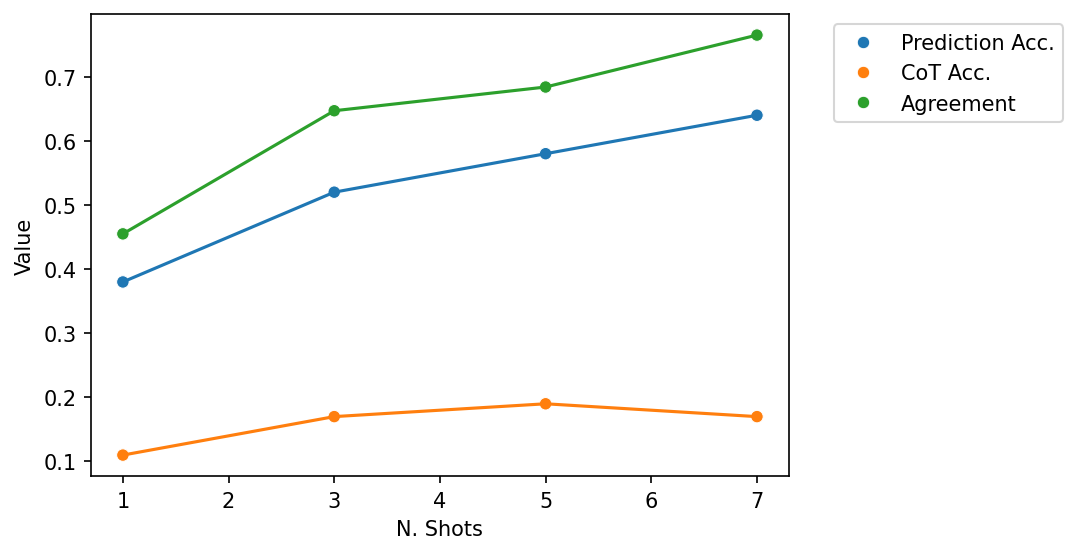

In [262]:
fig = plt.figure(figsize=(6, 4), dpi=150)

shots_results = pd.DataFrame({
    'N. Shots': [1, 3, 5, 7],
    'Prediction Acc.': [0.38, 0.52, 0.58, 0.64],
    'CoT Acc.': [0.11, 0.17, 0.19, 0.17],
    'Agreement': [0.455, 0.647, 0.684, 0.765]
})

sns.scatterplot(shots_results.melt(id_vars='N. Shots', var_name='Score', value_name='Value'), x='N. Shots', y='Value', hue='Score')
sns.lineplot(shots_results.melt(id_vars='N. Shots', var_name='Score', value_name='Value'), x='N. Shots', y='Value', hue='Score')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles[:len(handles)//2], labels=labels[:len(labels)//2], bbox_to_anchor=(1.05, 1), loc='upper left')

The model achieves an accuracy of 66% with 5 shots.

## Attribution analysis 

In [352]:
def logits_diff(logits, a_clean, a_corr=None):
    
    if isinstance(a_clean, str):
        a_clean = model.to_single_token(a_clean)
    if a_corr:
        if isinstance(a_corr, str):
            a_corr = model.to_single_token(a_corr)
        
        return logits[0, -1, a_clean] - logits[0, -1, a_corr]
    else:
        return logits[0, -1, a_clean]
    
def get_cache_fwd_and_bwd(tokens, a_clean, a_corr=None):
        filter_not_qkv_input = lambda name: "_input" not in name
        model.reset_hooks()
        cache = {}

        def forward_cache_hook(act, hook):
            cache[hook.name] = act.detach()

        model.add_hook(filter_not_qkv_input, forward_cache_hook, "fwd")

        grad_cache = {}

        def backward_cache_hook(act, hook):
            grad_cache[hook.name] = act.detach()

        model.add_hook(filter_not_qkv_input, backward_cache_hook, "bwd")

        value = logits_diff(model(tokens), a_clean, a_corr)
        value.backward()
        model.reset_hooks()
        return (
            value.item(),
            ActivationCache(cache, model),
            ActivationCache(grad_cache, model),
        )

def generate_until_stop(prompt, stop_token=':'):
    if isinstance(stop_token, str):
        stop_token = model.to_single_token(stop_token)
        
    tokens = model.to_tokens(prompt)
    gen = True
    while gen:
        with torch.no_grad():
            new_tok = model(tokens).argmax(-1)[:, -1]

        tokens = torch.cat([tokens, new_tok[None]], dim=-1)
        if new_tok.item() == stop_token:
            gen = False

    return model.to_string(tokens)

In [353]:
idx = 0
x_clean = correct_preds['prompt'].iloc[idx]
a_clean = correct_preds['label'].iloc[idx]
x_corr = correct_preds['prompt_corr'].iloc[idx]
cot_gold = correct_preds['cot_gold'].iloc[idx]

In [354]:
print(x_clean)

Answer True or False to the following question. Answer as in the examples.

Dumpuses are numpuses. Impuses are jompuses. Each yumpus is not spicy. Every dumpus is mean. Lorpuses are snowy. Each lempus is not transparent. Numpuses are tumpuses. Numpuses are moderate. Every tumpus is luminous. Jompuses are not blue. Impuses are gorpuses. Every gorpus is not hot. Each dumpus is a yumpus. Every gorpus is a lempus. Lorpuses are sterpuses. Every impus is muffled. Every numpus is an impus. Gorpuses are rompuses. Polly is an impus. Polly is a lorpus.
Question: Is Polly muffled?
Think step-by-step.

(1) Polly is an impus.
(2) Every impus is muffled.
(3) Polly is muffled.
Answer: True

Every lempus is a rompus. Each rompus is a jompus. Each jompus is a lorpus. Each rompus is a tumpus. Grimpuses are feisty. Jompuses are cold. Each dumpus is transparent. Each lempus is a dumpus. Rompuses are rainy. Vumpuses are gorpuses. Each tumpus is earthy. Every vumpus is sweet. Jompuses are grimpuses. Lempuse

In [357]:
print("Generating...")
clean_out = generate_until_stop(x_clean, [' True', ' False'])[0]
corr_out = generate_until_stop(x_corr, [' True', ' False'])[0]

Generating...


KeyboardInterrupt: 

In [ ]:
print(x_clean)

In [274]:
print("CLEAN RUN\n", clean_out.split("False:")[-1], sep='')
print("\nCORRUPTED RUN\n", corr_out.split("False:")[-1], sep='')

CLEAN RUN
 Wren is blue. Think step-by-step.

(1) Wren is a tumpus.
(2) Tumpuses are blue.
(3) Wren is blue.
Answer: True

CORRUPTED RUN
 Wren is not blue. Think step-by-step.

(1) Wren is a tumpus.
(2) Tumpuses are blue.
(3) Wren is not blue.
Answer: True


In [226]:
def caching_hook(x, hook, cache):
    cache[hook] = x
    return x

In [125]:
from functools import partial

clean_cache = {}
corr_cache = {}

clean_caching_fn = partial(caching_hook, cache=clean_cache)
corr_caching_fn = partial(caching_hook, cache=corr_cache)

component = 'resid_pre'

# Tokenization and caching
idx = 1
x_clean, a_clean, _, x_corr = prompt
a_corr = ' False' if eval(a_clean) else ' True'
a_clean = ' ' + a_clean

x_clean = generate_until_stop(x_clean)[0]
x_corr = generate_until_stop(x_corr)[0]

clean_tokens = model.to_tokens(x_clean, prepend_bos=False)
with torch.no_grad():
    clean_logits = model.run_with_hooks(clean_tokens, fwd_hooks=[
        (utils.get_act_name(component, layer), clean_caching_fn) for layer in range(model.cfg.n_layers)
        ])

clean_logit_diff = logits_diff(clean_logits, a_clean, a_corr)
print(f"Clean logit difference: {clean_logit_diff.item():.3f}")

corr_tokens = model.to_tokens(x_corr, prepend_bos=False)
with torch.no_grad():
    corr_logits = model.run_with_hooks(corr_tokens, fwd_hooks=[
        (utils.get_act_name(component, layer), corr_caching_fn) for layer in range(model.cfg.n_layers)
        ])

corr_logit_diff = logits_diff(corr_logits, a_clean, a_corr)
print(f"Clean logit difference: {corr_logit_diff.item():.3f}")

Clean logit difference: -0.625
Clean logit difference: -0.500


In [126]:
x_clean, x_corr

('<bos>Answer True or False to the following question. Answer as in the following examples.\n\nYumpuses are grimpuses. Impuses are sterpuses. Sterpuses are dumpuses. Each sterpus is a numpus. Each impus is windy. Lempuses are melodic. Rompuses are lorpuses. Rompuses are not earthy. Numpuses are sweet. Rompuses are impuses. Sterpuses are transparent. Every yumpus is not dull. Lorpuses are luminous. Impuses are lempuses. Alex is a rompus. Alex is a yumpus.\nTrue or False: Alex is earthy. Think step-by-step.\n\n(1) Alex is a rompus.\n(2) Rompuses are not earthy.\n(3) Alex is not earthy.\n\nAnswer: False\n\n\nEvery impus is a tumpus. Sterpuses are jompuses. Impuses are grimpuses. Each sterpus is not large. Grimpuses are not fast. Every impus is not red. Lorpuses are not happy. Every tumpus is a rompus. Every tumpus is a lorpus. Every lorpus is a sterpus. Rompuses are metallic. Each tumpus is muffled. Every jompus is not aggressive. Gorpuses are sunny. Every lorpus is a gorpus. Shumpuses ar

In [ ]:
_, corrupted_cache = self.model.run_with_cache(self.corrupted_tokens)
_, clean_cache, clean_grad_cache = self.get_cache_fwd_and_bwd(self.clean_tokens)

In [12]:
import einops
from tqdm import tqdm

_, cache, grad_cache = get_cache_fwd_and_bwd(
    model.to_tokens(out), 
    a_clean, a_corr
)

act = cache.stack_head_results(-1)
grad_act = grad_cache.stack_head_results(-1)

patch = einops.reduce(
            grad_act *  act,
            "component batch pos d_model -> component pos",
            "sum",
        )

In [22]:
import plotly.express as px

str_tokens = model.to_str_tokens(out, prepend_bos=False)[0]
n_last_tokens = 32

ys = [f'L{i}H{j}' for i in range(model.cfg.n_layers) for j in range(model.cfg.n_heads)]
xs = [f"{tok} | {i}" for i, tok in enumerate(str_tokens[-n_last_tokens:])]

fig = px.imshow(
    patch[:, -n_last_tokens:].cpu().numpy(), 
    x=xs,
    y=ys,
    title=f"Patching results for AtP method",
    color_continuous_scale='RdBu', zmin=-1, zmax=1, aspect='auto'
)
fig.write_html("fig.html")